In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(device)

cuda


In [4]:
# Load data
train = pd.read_csv(r"../input/digit-recognizer/train.csv", dtype=np.float32)

# split data into X(pixels) and Y(numbers from 0 to 9)
X = train.loc[:,train.columns != "label"].values/255
Y = train.label.values


# train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size = 0.2,
                                                    random_state=42)

# create X and Y tensor
X_train = torch.from_numpy(X_train)
Y_train = torch.from_numpy(Y_train).type(torch.LongTensor)

X_test = torch.from_numpy(X_test)
Y_test = torch.from_numpy(Y_test).type(torch.LongTensor)

# batch size, epoch and iteration
batch_size =100
epochs = 30

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(X_train, Y_train)
test = torch.utils.data.TensorDataset(X_test, Y_test)

# Data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

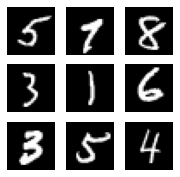

In [5]:
# sample 9 mnist digits from train dataset

index = np.random.randint(0, X_train.shape[0], size=9)
images = X_train[index]
labels = Y_train[index]

plt.figure(figsize=(3,3))
for i in range(len(index)):
    plt.subplot(3, 3, i + 1)
    image = images[i].reshape(28, 28)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
plt.show()

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
    
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=0)
        
        # BatchNormalization 1 
        self.batch1 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout
        self.drop1 = nn.Dropout(p=0.25)
        
        # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        
        # Convolution 4 - BatchNormalization 2
        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.batch2 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout 2
        self.drop2 = nn.Dropout(p=0.25)
        
        
        # Fully connected 1
        self.fc1 = nn.Linear(64 * 3 * 3, 256)
        self.batch3 = nn.BatchNorm1d(256)
        self.relu4 = nn.ReLU()
        
        # Fully connected 2
        self.fc2 = nn.Linear(256, 128)
        self.batch4 = nn.BatchNorm1d(128)
        self.relu5 = nn.ReLU()
        
        # Fully connected 3
        self.fc3 = nn.Linear(128,84)
        self.batch5 = nn.BatchNorm1d(84)
        self.relu6 = nn.ReLU()
        self.drop2 = nn.Dropout(p=0.25)
        
        # Fully connected 4
        self.fc4 = nn.Linear(84, 10)
        
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        
        # BatchNormalization 1
        out = self.batch1(out)
        out = self.relu2(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Dropout
        out = self.drop1(out)

        # Convolution 3
        out = self.cnn3(out)
        
        
        
        # Convolution 4 - BatchNormalization 2
        out = self.cnn4(out)
        out = self.batch2(out)
        out = self.relu3(out)
        
        # Max pool 2
        out = self.maxpool2(out)
        
        # Dropout 2
        out = self.drop2(out)
        
        # flatten
        out = out.view(out.size(0), -1)

        
        out = self.fc1(out)
        out = self.batch3(out)
        out = self.relu4(out)
        
        out = self.fc2(out)
        out = self.batch4(out)
        out = self.relu5(out)
        
        out = self.fc3(out)
        out = self.batch5(out)
        out = self.relu6(out)
        
        # Linear function (readout)
        out = self.fc4(out)
        
        

        
        return out

In [7]:
model = LeNet()
if torch.cuda.is_available():
    model.cuda()
# Define cost function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [8]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(epochs):
    for i, (X, Y) in enumerate(train_loader):
        X, Y = X.to(device), Y.to(device)
        train = Variable(X.view(100,1,28,28))
        labels = Variable(Y)
        
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = criterion(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        
    # Calculate Accuracy         
    correct = 0
    total = 0
    # Iterate through test dataset
    for X, Y in test_loader:
        
        X, Y = X.to(device), Y.to(device)
        test = Variable(X.view(100,1,28,28))
        
        # Forward propagation
        outputs = model(test)
                
        # Get predictions from the maximum value
        predicted = torch.max(outputs.data, 1)[1]
            
        # Total number of labels
        total += len(Y)
                
        correct += (predicted == Y).cpu().sum()
            
    accuracy = 100 * correct / float(total)
            
    # Print Loss
    print('Epoch: {}  Loss: {}  Accuracy: {} %'.format(epoch+1, loss.data, accuracy))

Epoch: 1  Loss: 0.02989070676267147  Accuracy: 97.20237731933594 %
Epoch: 2  Loss: 0.008631151169538498  Accuracy: 97.9047622680664 %
Epoch: 3  Loss: 0.009133796207606792  Accuracy: 98.23809814453125 %
Epoch: 4  Loss: 0.007761779241263866  Accuracy: 98.35713958740234 %
Epoch: 5  Loss: 0.00819863099604845  Accuracy: 98.36904907226562 %
Epoch: 6  Loss: 0.004077814053744078  Accuracy: 98.51190185546875 %
Epoch: 7  Loss: 0.005182452034205198  Accuracy: 98.54762268066406 %
Epoch: 8  Loss: 0.010982578620314598  Accuracy: 98.58333587646484 %
Epoch: 9  Loss: 0.0030440851114690304  Accuracy: 98.53571319580078 %
Epoch: 10  Loss: 0.004185467958450317  Accuracy: 98.72618865966797 %
Epoch: 11  Loss: 0.0022506648674607277  Accuracy: 98.78571319580078 %
Epoch: 12  Loss: 0.0019291798816993833  Accuracy: 98.71428680419922 %
Epoch: 13  Loss: 0.00923400279134512  Accuracy: 98.53571319580078 %
Epoch: 14  Loss: 0.006520270835608244  Accuracy: 98.86904907226562 %
Epoch: 15  Loss: 0.0018867036560550332  Accu

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [10]:
# Calculate Accuracy         
correct = 0
total = 0
pred_list = np.empty((1, 1), dtype=int)
y_list = np.empty((1, 1), dtype=int)

# Iterate through test dataset
for X, Y in test_loader:
                
    test = Variable(X.view(100,1,28,28).to(device))
    Y = Y.to(device)
    # Forward propagation
    outputs = model(test.to(device))
                
    # Get predictions from the maximum value
    predicted = torch.max(outputs.data, 1)[1]
    
    # Add pred and y value with ndarray
    predicted = predicted.to('cpu')
    predicted = predicted.numpy()
    pred_list = np.append(pred_list, predicted)
    
    Y = Y.to('cpu')
    Y = Y.numpy()
    y_list = np.append(y_list, Y)
    
    
pred_list = pred_list[1:]    
y_list = y_list[1:]

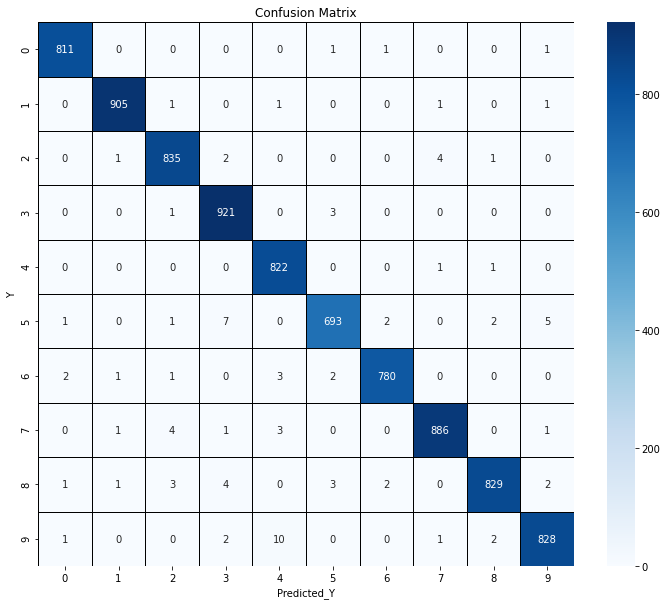

In [11]:
plt.subplots(figsize=(12,10))
sns.heatmap(confusion_matrix(pred_list, y_list), annot=True,
           linewidth=0.5, fmt='.0f', cmap='Blues', linecolor='black')

plt.xlabel('Predicted_Y')
plt.ylabel('Y')
plt.title('Confusion Matrix')
plt.show()

In [12]:
#save model
print('save model state dict keys: \n', model.state_dict().keys())
torch.save(model.state_dict(), 'checkpoint.pth')

save model state dict keys: 
 odict_keys(['cnn1.weight', 'cnn1.bias', 'cnn2.weight', 'cnn2.bias', 'batch1.weight', 'batch1.bias', 'batch1.running_mean', 'batch1.running_var', 'batch1.num_batches_tracked', 'cnn3.weight', 'cnn3.bias', 'cnn4.weight', 'cnn4.bias', 'batch2.weight', 'batch2.bias', 'batch2.running_mean', 'batch2.running_var', 'batch2.num_batches_tracked', 'fc1.weight', 'fc1.bias', 'batch3.weight', 'batch3.bias', 'batch3.running_mean', 'batch3.running_var', 'batch3.num_batches_tracked', 'fc2.weight', 'fc2.bias', 'batch4.weight', 'batch4.bias', 'batch4.running_mean', 'batch4.running_var', 'batch4.num_batches_tracked', 'fc3.weight', 'fc3.bias', 'batch5.weight', 'batch5.bias', 'batch5.running_mean', 'batch5.running_var', 'batch5.num_batches_tracked', 'fc4.weight', 'fc4.bias'])


In [13]:
# load model
state_dict = torch.load('checkpoint.pth')
print('load model state dict keys: \n', model.state_dict().keys())

load model state dict keys: 
 odict_keys(['cnn1.weight', 'cnn1.bias', 'cnn2.weight', 'cnn2.bias', 'batch1.weight', 'batch1.bias', 'batch1.running_mean', 'batch1.running_var', 'batch1.num_batches_tracked', 'cnn3.weight', 'cnn3.bias', 'cnn4.weight', 'cnn4.bias', 'batch2.weight', 'batch2.bias', 'batch2.running_mean', 'batch2.running_var', 'batch2.num_batches_tracked', 'fc1.weight', 'fc1.bias', 'batch3.weight', 'batch3.bias', 'batch3.running_mean', 'batch3.running_var', 'batch3.num_batches_tracked', 'fc2.weight', 'fc2.bias', 'batch4.weight', 'batch4.bias', 'batch4.running_mean', 'batch4.running_var', 'batch4.num_batches_tracked', 'fc3.weight', 'fc3.bias', 'batch5.weight', 'batch5.bias', 'batch5.running_mean', 'batch5.running_var', 'batch5.num_batches_tracked', 'fc4.weight', 'fc4.bias'])


In [14]:
# load test data
new_test = pd.read_csv('../input/digit-recognizer/test.csv').values
new_images = torch.from_numpy(new_test).type(torch.FloatTensor)/255
print(new_images.shape)
new_test_loader = DataLoader(new_images, batch_size=batch_size, shuffle=False)

torch.Size([28000, 784])


In [15]:
results = []
with torch.no_grad():
    model.eval()                          
        
    for images in new_test_loader:
        images = Variable(images.view(batch_size,1,28,28))
        
        if torch.cuda.is_available():
            images = images.cuda()
        
        
        outputs = model(images)
        
        predict = outputs.cpu().data.max(1, keepdim=True)[1]
        #predict = torch.max(outputs.data, 1)[1]
        results += predict.numpy().tolist()
        
print(results[:10])
print(len(results))

[[2], [0], [9], [9], [3], [7], [0], [3], [0], [3]]
28000


In [16]:
results = np.array(results).flatten()
print(results[:10])
print(results.shape)

[2 0 9 9 3 7 0 3 0 3]
(28000,)


In [17]:
submission = pd.DataFrame({'ImageId': list(range(1, len(results)+1)),
                          'Label': results})
submission.to_csv('submission.csv',index=False, header=True)
print(submission[:10])

   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      9
4        5      3
5        6      7
6        7      0
7        8      3
8        9      0
9       10      3
